In [1]:
#plot conv speed of octopus example rho=1.5
# Compute the Gromov-Wasserstein distance
#P = sgw.supervised_gromov_wasserstein(geo1, geo2, nitermax=20, threshold=1.5)
import itertools
import networkx as nx
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import random

In [2]:
C1 = np.loadtxt('geodesic_C1_1203.csv', delimiter=',')
#geodesic_C2_1122 is for more downsampled data to see the head
C2 = np.loadtxt('geodesic_C2_1203.csv', delimiter=',')

n = C1.shape[0]
m = C2.shape[0]
threshold = 2
random_state=1
np.random.seed(random_state)
random.seed(random_state)
print(n,m)

# Build graph
G = nx.Graph()
for i in range(n):
    for j in range(m):
        vertex = (i + 1, j + 1)
        G.add_node(vertex)

tensor4 = np.zeros((n, m, n, m))
C1_exp = C1[:, None, :, None]
C2_exp = C2[None, :, None, :]
tensor4 = (C1_exp - C2_exp) ** 2

positions = np.where(tensor4 > threshold ** 2)
vertex_positions = positions[0] + 1, positions[1] + 1, positions[2] + 1, positions[3] + 1

for i in range(len(positions[0])):
    first_elements = [arr[i] for arr in vertex_positions]
    vertex1 = (first_elements[0], first_elements[1])
    vertex2 = (first_elements[2], first_elements[3])
    G.add_edge(vertex1, vertex2)

144 127


In [3]:
def vertex_with_most_edges(graph):
    degrees = dict(graph.degree())     
    max_degree = max(degrees.values())
    max_degree_vertices = [vertex for vertex, degree in degrees.items() if degree == max_degree]

    return max_degree_vertices, max_degree

tuples_set = set()
B = G.copy()

while B.edges:
    vertices, degree = vertex_with_most_edges(B)
    vertex = random.choice(vertices)
    B.remove_node(vertex)
    tuples_set.add(vertex)

if not B.edges:
    print("No more edges in the graph.") 

No more edges in the graph.


In [4]:
gamma = 10
eps = 1e-2
eta = 1
verbose = False
nitermax = 20
random_state=1
np.random.seed(random_state)

def perform_sOT_log(G, a, b, eps, options):

    niter = options['niter_sOT']
    f     = options['f_init']
    g     = options['g_init']
    M     = options['penalty']

    # Err = np.array([[1, 1]])

    for q in range(niter):   
        f = np.minimum(eps * np.log(a) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=1)+ 10**-20) + f, M)
        g = np.minimum(eps * np.log(b) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=0)+ 10**-20) + g, M)

    P = np.exp((f[:, None] + g[None, :] - G) / eps)
    
    return P, f, g


a = np.array([1 / n] * n, dtype=float)
aa = a + 1e-1 * np.random.rand(n)
b = np.array([1 / m] * m, dtype=float)
bb = b + 1e-1 * np.random.rand(m)

aa = aa / np.linalg.norm((aa), ord=1)
bb = bb / np.linalg.norm((bb), ord=1)
    
#real convergence value
#eta = eps/(np.sqrt(2)* n * m * min(np.max(a), np.max(b)) * max(np.max(C1)**2,np.max(C2)**2) + eps)
    
    
P = np.outer(aa, bb) 
f = np.zeros(n)
g = np.zeros(m)
p_values = range(nitermax)
sgw_values = []

print(max(np.max(C1)**2,np.max(C2)**2))

for p in p_values:
        
    D = np.zeros((n, m)) 
    P_reshaped = P.reshape(1, 1, n, m) 
    D = np.sum(tensor4 * P_reshaped, axis=(-2, -1))
    sgw = np.sum(D * P)+gamma*(np.sum(a)+np.sum(b)-2*np.sum(P))+eps*np.sum(P * (np.log(P+10**(-20)*np.ones((n,m)))-np.ones((n,m))))
    sgw_values.append(sgw)
    
    D = 2*eta*D+eps*(eta-1)*np.log(P+10**(-20)*np.ones((n,m)))
                    
    for s, t in tuples_set:
        D[s-1, t-1] = np.inf
        
    options = {
    'niter_sOT': 10**5,
    'f_init': np.zeros(n),
    'g_init': np.zeros(m),
    'penalty': eta*gamma
    }
        
    P,f,g = perform_sOT_log(D, a, b, eps, options)

4.16938103169375


In [5]:
np.savetxt('sgw_rho_2.txt', sgw_values)
sgw_values

[0.3108921243826232,
 0.3330059548137708,
 0.3041401942129951,
 0.2678700794563322,
 0.24985387699350398,
 0.24503060265269277,
 0.24211912591098061,
 0.24200431844560755,
 0.24194289325529128,
 0.24186328448877592,
 0.2416951365247953,
 0.24131804747391666,
 0.2411275450733401,
 0.24109056917611738,
 0.24108376567543088,
 0.24108205911475994,
 0.2410812609428265,
 0.24108071742436832,
 0.24108030180226253,
 0.24107997428829686]

In [8]:
import matplotlib.pyplot as plt

# Provided data points
y_values = [
0.3108921243826232-0.24107997428829686,
0.3330059548137708-0.24107997428829686,
0.3041401942129951-0.24107997428829686,
0.2678700794563322-0.24107997428829686,
0.24985387699350398-0.24107997428829686,
0.24503060265269277-0.24107997428829686,
0.24211912591098061-0.24107997428829686,
0.24200431844560755-0.24107997428829686,
0.24194289325529128-0.24107997428829686,
0.24186328448877592-0.24107997428829686,
0.2416951365247953-0.24107997428829686,
0.24131804747391666-0.24107997428829686,
0.2411275450733401-0.24107997428829686,
0.24109056917611738-0.24107997428829686,
0.24108376567543088-0.24107997428829686,
0.24108205911475994-0.24107997428829686,
0.2410812609428265-0.24107997428829686,
0.24108071742436832-0.24107997428829686,
0.24108030180226253-0.24107997428829686,
0.24107997428829686-0.24107997428829686
]

# Generating x values as indices of the list
x_values = list(range(len(y_values)))

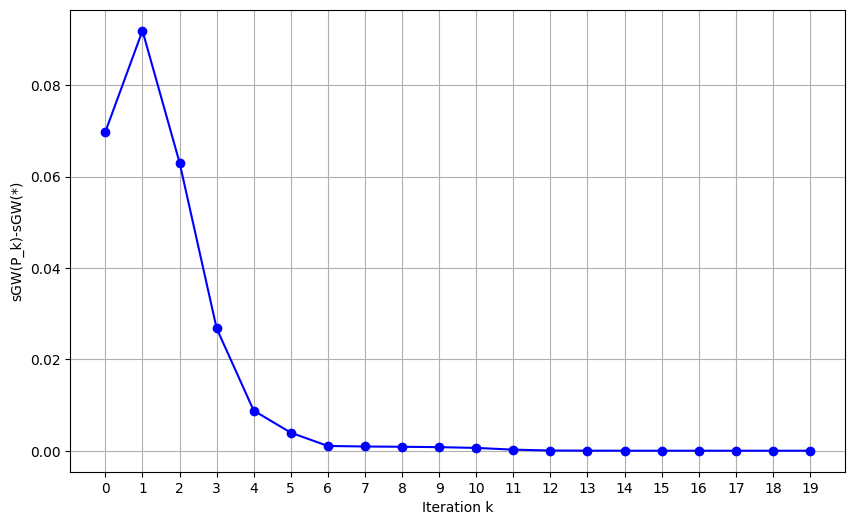

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
#plt.title('Data Set Plot')
plt.xlabel('Iteration k')
plt.ylabel('sGW(P_k)-sGW(*)')
plt.grid(True)
plt.xticks(x_values)  # Ensure x values are integers
plt.savefig('oc_rho_2_sgw.png', dpi=300, bbox_inches='tight')
